In [1]:
import torch
import random
from d2l import torch as d2l
import matplotlib.pyplot as plt
%matplotlib inline

# 构造一个数据集,以w和b为参数，添加噪声即可

In [2]:
def synthetic_data(w, b, num_examples):
    """y = Xw + b + 噪声"""
    X = torch.normal(0, 1, size=(num_examples, len(w)))
#     print(w.shape)
#     print(X.shape)
    y = torch.matmul(X, w) + b  # torch.matmul约等于mv与mm,dot三个函数
#     print(y.shape)
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2, -3.4])
true_b = 4.2

features, labels = synthetic_data(true_w, true_b, 1000)

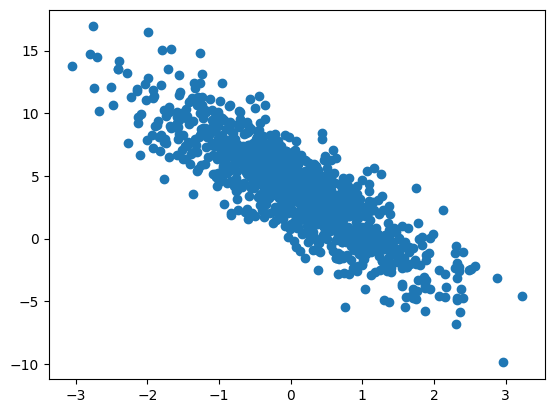

In [3]:
plt.scatter(features[:, 1], labels)

In [4]:
def data_batch(batch_size, features, labels):
    """
    自己写的划分batch代码，主要问题有:
    1.shuffle时对每个batch的编号进行了shuffle，
    所以实际上划分出来的batch只是原本数据中对应编号*batch_size-对应编号+batchsize的数据集合，
    比如以batch_size为10为例，编号为2时，获得的仍然是原数据中第20个-第20+10-1个数据，这些数据的相对位置并没有打乱
    
    2.for循环中的索引完全相同，所以可以单独用一个变量表示
    """
    batch_num = len(labels) // batch_size + 1
    indices = list(range(batch_num))
    random.shuffle(indices)
    print(indices)
    
    for i in indices:
        fea_batch = features[i*batch_size:min((i+1)*batch_size, len(features))]
        lab_batch = labels[i*batch_size:min((i+1)*batch_size, len(features))]
        
        yield fea_batch, lab_batch
        
batch_size=35

for X, y in data_batch(batch_size, features, labels):
    print(y.shape)

[15, 28, 13, 17, 6, 16, 9, 25, 5, 10, 22, 7, 27, 11, 1, 24, 12, 4, 18, 26, 23, 3, 0, 20, 8, 14, 21, 19, 2]
torch.Size([35, 1])
torch.Size([20, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])
torch.Size([35, 1])


In [5]:
def data_iter(batch_size, features, labels):
    total_num = len(features)
    indices = list(range(total_num))
    random.shuffle(indices)
    
    for i in range(0, total_num, batch_size):
        batch_indice = indices[i:min(i+batch_size, total_num)]
        
        fea_batch = features[batch_indice]
        lab_batch = labels[batch_indice]
        
        yield fea_batch, lab_batch  # yield与return同等级，但yield分次执行，调用一次next执行一次
        
batch_size = 65
for X,y in data_iter(batch_size, features, labels):
    print(X.shape)

torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([65, 2])
torch.Size([25, 2])


# 初始化模型参数

In [6]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
# b = torch.zeros_like(labels, requires_grad=True) 反例
b = torch.zeros(1, requires_grad=True)  # 利用广播机制，否则在分批次时容易出现向量对不齐的情况

In [7]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

In [8]:
def squared_loss(y_hat, y):
    return 1/2 * (y_hat - y.reshape(y_hat.shape)) ** 2  # 可能一个为行向量一个为列向量，故使用reshape调整至相同形状

In [9]:
def sgd(params, lr, batch_size):
    """随机梯度下降"""
    # params为一个参数列表
    # sgd实际传入的是引用，因此w和b可以被改变
    with torch.no_grad():  # 更新参数时不需要计算梯度
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()  # 自动清除梯度，防止梯度累计

In [10]:
lr = 0.03
num_epoch = 5
model = linreg
loss = squared_loss

for epoch in range(num_epoch):
    for X, y in data_iter(batch_size, features, labels):
        y_hat = model(X, w, b)
        l = loss(y_hat, y)  # l是一个长为batch_size大小的向量
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # sgd实际传入的是引用，因此w和b可以被改变
    with torch.no_grad():
        train_l = loss(model(features, w, b), labels)  # 计算整个数据集的loss
        print(f'epoch{epoch+1}, loss{float(train_l.mean())}')

epoch1, loss6.444716453552246
epoch2, loss2.716700792312622
epoch3, loss1.145408034324646
epoch4, loss0.4827690124511719
epoch5, loss0.2034820318222046


In [11]:
# w和b的估计误差
print(true_w)
print(w)
print(f'w的估计误差为{true_w - w.reshape(true_w.shape)}')  # w和true_w可能对不齐，使用reshape
print(f'b的估计误差为{true_b - b}')

tensor([ 2.0000, -3.4000])
tensor([[ 1.7704],
        [-3.0056]], requires_grad=True)
w的估计误差为tensor([ 0.2296, -0.3944], grad_fn=<SubBackward0>)
b的估计误差为tensor([0.4831], grad_fn=<RsubBackward1>)


# 简洁实现

In [12]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l
import torch.nn as nn

In [22]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)  # 人工生成数据
print(features.shape)
print(labels.shape)

torch.Size([1000, 2])
torch.Size([1000, 1])


In [23]:
def load_array(data_arrays, batch_size, is_train=True):
    """借助API构造一个dataloader"""
    # 将第一个维度长度相等的向量一一对应地组合在一起
    # eg:每一个元素为tensor(feature, label)
    dataset = data.TensorDataset(*data_arrays)  
    return data.DataLoader(dataset, batch_size, shuffle=True)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[ 0.9437, -0.1467],
        [ 2.3130,  0.3927],
        [ 0.9659,  1.0598],
        [ 1.4067,  1.6072],
        [ 1.7872, -0.0613],
        [-0.7752, -1.2229],
        [ 0.4261,  0.2299],
        [-1.0937,  0.6101],
        [-0.1682, -0.7411],
        [-1.1005,  1.8728]]) 
 tensor([[ 6.5880],
        [ 7.4690],
        [ 2.5458],
        [ 1.5465],
        [ 7.9881],
        [ 6.7963],
        [ 4.2743],
        [-0.0635],
        [ 6.3860],
        [-4.3701]])


In [24]:
model = nn.Sequential(nn.Linear(2, 1))  # 线性回归即为单层的神经网络

# 初始化模型参数

In [25]:
# model[0].weight.data.normal_(0, 0.01)  # 通过weight访问w，用normal_来替换原有w
# model[0].bias.data.fill_(0)
print(f"w:{model[0].weight.data}")
print(f"b:{model[0].bias.data}")

w:tensor([[ 0.6544, -0.5912]])
b:tensor([0.4726])


In [26]:
loss = nn.MSELoss()

In [27]:
for i in model.parameters():
    print(i)

Parameter containing:
tensor([[ 0.6544, -0.5912]], requires_grad=True)
Parameter containing:
tensor([0.4726], requires_grad=True)


In [28]:
trainer = torch.optim.SGD(model.parameters(), lr=0.03)

In [29]:
num_epoch = 10
for epoch in range(num_epoch):
    for X, y in data_iter:
        l = loss(model(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
        
    l = loss(model(features), labels)
    print(f'epoch{epoch+1}, loss{l:f}')

epoch1, loss0.000216
epoch2, loss0.000101
epoch3, loss0.000100
epoch4, loss0.000100
epoch5, loss0.000101
epoch6, loss0.000100
epoch7, loss0.000100
epoch8, loss0.000100
epoch9, loss0.000100
epoch10, loss0.000100


In [30]:
print(model[0].weight)
print(model[0].bias)

Parameter containing:
tensor([[ 1.9998, -3.4004]], requires_grad=True)
Parameter containing:
tensor([4.2003], requires_grad=True)
